In [1]:
import torch
print("Torch version:", torch.__version__)

Torch version: 2.5.1+cu121


In [5]:
%pip install -U segment-geospatial[samgeo3]

Note: you may need to restart the kernel to use updated packages.


In [3]:
import leafmap
from samgeo import SamGeo3

In [4]:
from huggingface_hub import login, whoami

login(token="************")

info = whoami()
print("Login successful!")
print("Logged in as:", info["name"])

Login successful!
Logged in as: subhamofficwork


In [5]:
from samgeo.samgeo3 import SAM3_META_AVAILABLE, SAM3_TRANSFORMERS_AVAILABLE
print("META available:", SAM3_META_AVAILABLE)
print("TRANSFORMERS available:", SAM3_TRANSFORMERS_AVAILABLE)

META available: False
TRANSFORMERS available: True


In [9]:
from samgeo import SamGeo3

sam3 = SamGeo3(
    backend="transformers",
    device=None,            
    load_from_HF=True
)

print("SAM3 Transformers backend loaded ✅")

Using cuda device and transformers backend


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

SAM3 Transformers backend loaded ✅


In [47]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd

raster_path = r"E:\SamGeo3\Bhuvan2.tif"
aoi_path = r"E:\SamGeo3\Aoi2.shp"
output_path = r"E:\SamGeo3\Bhuvan2_.tif"

aoi = gpd.read_file(aoi_path)

with rasterio.open(raster_path) as src:
    if aoi.crs != src.crs:
        aoi = aoi.to_crs(src.crs)

    clipped_image, clipped_transform = mask(
        src,
        aoi.geometry,
        crop=True,
        all_touched=False  
    )

    out_meta = src.meta.copy()
    out_meta.update({
        "height": clipped_image.shape[1],
        "width": clipped_image.shape[2],
        "transform": clipped_transform
    })

with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(clipped_image)

In [49]:
sam3.set_image("E:\SamGeo3\Bhuvan2_.tif")

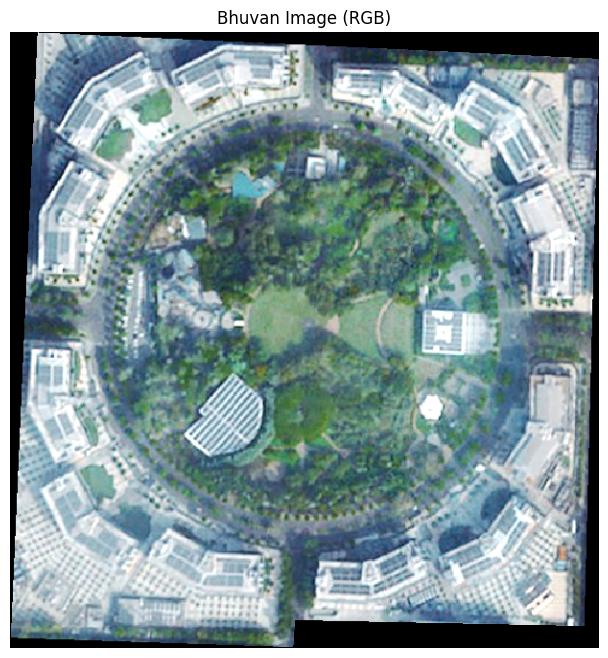

In [51]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

tif_path = r"E:\SamGeo3\Bhuvan2_.tif"

with rasterio.open(tif_path) as src:
    img = src.read([1, 2, 3])
    img = np.transpose(img, (1, 2, 0))

img = img.astype(np.float32)
p2, p98 = np.percentile(img, (2, 98))
img = np.clip((img - p2) / (p98 - p2), 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("Bhuvan Image (RGB)")
plt.axis("off")
plt.show()

In [53]:
sam3.generate_masks(
    prompt="buildings",
    min_size=50,
    output=r"E:\SamGeo3\Building_masks2.tif"
)

Found 18 objects.


In [57]:
sam3.save_masks(r"E:\SamGeo3\Building_masks2.tif")

Saved 18 mask(s) to E:\SamGeo3\Building_masks2.tif


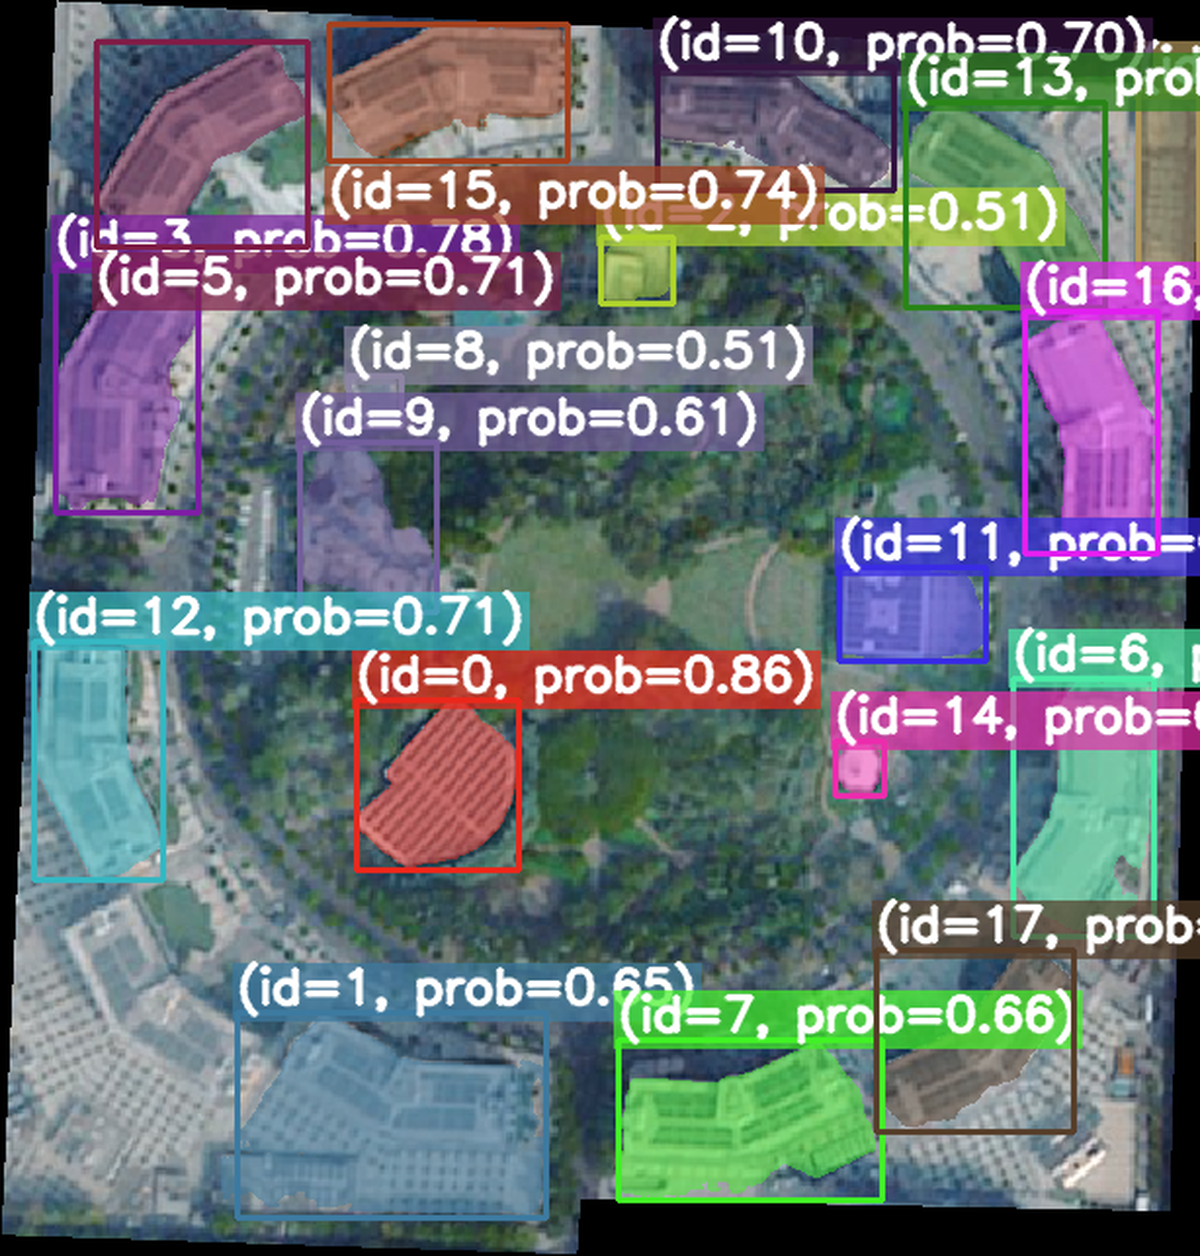

In [59]:
sam3.show_anns()

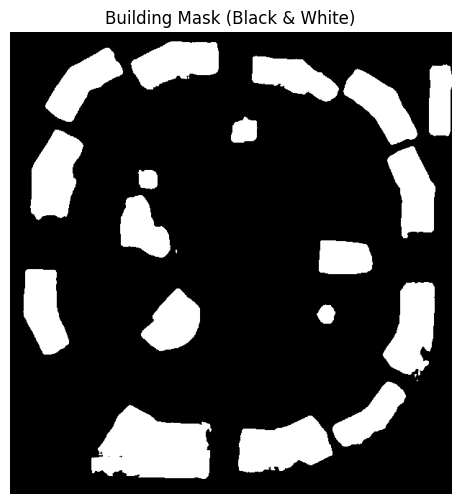

In [61]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

mask_path = r"E:\SamGeo3\Building_masks2.tif"

with rasterio.open(mask_path) as src:
    mask = src.read(1)

binary_mask = (mask > 0).astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(binary_mask, cmap="gray")
plt.title("Building Mask (Black & White)")
plt.axis("off")
plt.show()

In [63]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

raster_path = r"E:\SamGeo3\Building_masks2.tif"
vector_path = r"E:\SamGeo3\Building_masks2.shp"

with rasterio.open(raster_path) as src:
    mask = src.read(1)
    transform = src.transform
    crs = src.crs
    
geoms = []
for geom, value in shapes(mask, transform=transform):
    if value > 0:
        geoms.append(shape(geom))

gdf = gpd.GeoDataFrame(geometry=geoms, crs=crs)

gdf.to_file(vector_path)

print("✅ Raster converted to vector and saved:", vector_path)

✅ Raster converted to vector and saved: E:\SamGeo3\Building_masks2.shp


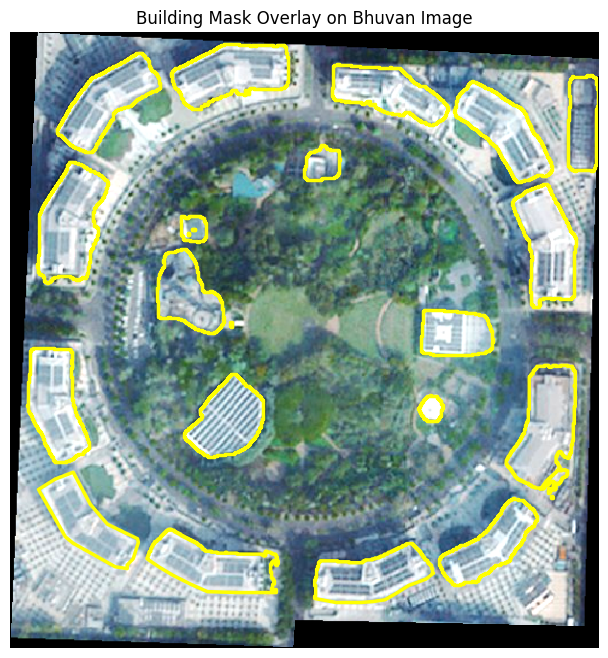

In [67]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

img_path = r"E:\SamGeo3\Bhuvan2_.tif"
shp_path = r"E:\SamGeo3\Building_masks2.shp"

with rasterio.open(img_path) as src:
    img = src.read([1, 2, 3]).transpose(1, 2, 0)
    extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top
    ]

img = img.astype(np.float32)
p2, p98 = np.percentile(img, (2, 98))
img = np.clip((img - p2) / (p98 - p2), 0, 1)

gdf = gpd.read_file(shp_path)

with rasterio.open(img_path) as src:
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)

fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(img, extent=extent)

gdf.plot(
    ax=ax,
    edgecolor="yellow",
    facecolor="none",
    linewidth=2.5
)

ax.set_title("Building Mask Overlay on Bhuvan Image")
ax.set_axis_off()

plt.show()